<a href="https://colab.research.google.com/github/jiin-son/credit_card_fraud_detection/blob/main/Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection

To avoid 1) overfitting, 2) improve the model performance, and 3) reduce the rumtime, feature selection before modelling is necessary. /n
oversampling didn't imporve pricision score

### 1. Load Package, Definition, and Data
#### 1.1. Load Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

#### 1.2. Load Data

In [2]:
# Choose the file from directory
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Logistic Regression
Run logistic Regression without feature selection (for comparison purposes)

In [ ]:
# Store column names only for input vaiables excluding target variable ('Class')
cols = [col for col in df.columns if col != 'Class']

# Split the dataset
X = df[cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [ ]:
# run logistic regression using all the variables
log_reg= LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=log_reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


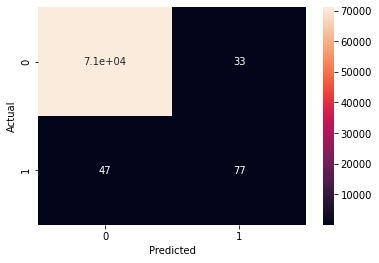

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
# get the accuracy, f1 score, precision, recall, and area under the roc curve
print("accuracy_score :", "{:.2%}".format(accuracy_score(y_test, y_pred)))
print("f1_score :", "{:.2%}".format(f1_score(y_test, y_pred)))
print("precison_score (=tpr=sensitivity):", "{:.2%}".format(precision_score(y_test, y_pred)))
print("recall_score :", "{:.2%}".format(recall_score(y_test, y_pred)))
print("roc_auc_score :", "{:.2%}".format(roc_auc_score(y_test, y_pred)))


accuracy_score : 99.89%
f1_score : 65.81%
precison_score (=tpr=sensitivity): 70.00%
recall_score : 62.10%
roc_auc_score : 81.03%


accuracy matrix not reliable due to highly unbalance data. how to evaluate fpr/fnr?

### 3. Resampling
1. **split**: splitting first and oversampling only the tran data so that we don't need to necessarily change anything from the test data. 
2. **transformation/standardization**: "Amount" and "Time" variable only - other variables are already standardized from the PCA process (initial data processing)
3. **oversampling**

In [ ]:
# 1. Split
# Column names only for top9  with 'Amount' from random forest feature importance
feature_selection = ['V17', 'V14', 'V12', 'V10', 'V26', 'V4', 'V7', 'V27', 'Time', 'Amount']

# Split the dataset
X = df[feature_selection]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [ ]:
# 2. Standardization: "Amount", "Time"
from sklearn.preprocessing import StandardScaler

for col in ["Amount", "Time"]:
    scaler = StandardScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
# 3. oversampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 368
Before OverSampling, counts of label '0': 213237 



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (426474, 10)
After OverSampling, the shape of train_y: (426474,) 

After OverSampling, counts of label '1': 213237
After OverSampling, counts of label '0': 213237


In [ ]:
# fit the model
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 42, n_jobs = -1)
rfc.fit(X_train_res, y_train_res)
y_pred = rfc.predict(X_test)

In [ ]:
# get the accuracy, f1 score, precision, recall, and area under the roc curve
print("accuracy_score :", "{:.2%}".format(accuracy_score(y_test, y_pred)))
print("f1_score :", "{:.2%}".format(f1_score(y_test, y_pred)))
print("precison_score (=tpr=sensitivity):", "{:.2%}".format(precision_score(y_test, y_pred)))
print("recall_score :", "{:.2%}".format(recall_score(y_test, y_pred)))
print("roc_auc_score :", "{:.2%}".format(roc_auc_score(y_test, y_pred)))

accuracy_score : 99.93%
f1_score : 79.67%
precison_score (=tpr=sensitivity): 80.33%
recall_score : 79.03%
roc_auc_score : 89.50%


In [ ]:
# run logistic regression using all the variables
log_reg= LogisticRegression()
log_reg.fit(X_train_res,y_train_res)
y_pred=log_reg.predict(X_test)

In [ ]:
# get the accuracy, f1 score, precision, recall, and area under the roc curve
print("accuracy_score :", "{:.2%}".format(accuracy_score(y_test, y_pred)))
print("f1_score :", "{:.2%}".format(f1_score(y_test, y_pred)))
print("precison_score (=tpr=sensitivity):", "{:.2%}".format(precision_score(y_test, y_pred)))
print("recall_score :", "{:.2%}".format(recall_score(y_test, y_pred)))
print("roc_auc_score :", "{:.2%}".format(roc_auc_score(y_test, y_pred)))

accuracy_score : 97.25%
f1_score : 10.28%
precison_score (=tpr=sensitivity): 5.45%
recall_score : 90.32%
roc_auc_score : 93.79%


### 4. Feature Selection
1. **split**: splitting first and oversampling only the tran data so that we don't need to necessarily change anything from the test data. 
2. **transformation/standardization**: "Amount" and "Time" variable only - other variables are already standardized from the PCA process (initial data processing)
3. **oversampling**
4. **SelectFromModel**
5. **split with the selected features**
6. **no need to transformation/standardization**: no "Amount" or "Time" variable were selected
7. **oversampling**
8. **train/fit the model**
9. **evalate the metrics**




In [34]:
# Split the dataset
cols = [col for col in df.columns if col != 'Class']
X = df[cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [35]:
from sklearn.preprocessing import StandardScaler
for col in ["Amount", "Time"]:
    scaler = StandardScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [36]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 368
Before OverSampling, counts of label '0': 213237 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (426474, 30)
After OverSampling, the shape of train_y: (426474,) 

After OverSampling, counts of label '1': 213237
After OverSampling, counts of label '0': 213237


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
# performing variable selection after using SMOTE should be done with some care because most variable selection methods assume that the samples are independent.
sel = SelectFromModel(RandomForestClassifier(random_state = 42, n_jobs = -1)) #n_estimators = 100
sel.fit(X_train_res, y_train_res) # time: 3m 58s

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 oob_score=False,
 

In [52]:
print(sel.get_support())


In [39]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

9

In [40]:
print(selected_feat)

Index(['V2', 'V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')


using the selected features - train the model

In [43]:
X = df[selected_feat]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
X_train.shape

(213605, 9)

In [46]:
# no need to do standardization
#from sklearn.preprocessing import StandardScaler
#for col in ["Amount", "Time"]:
#    scaler = StandardScaler()
#    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
#    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

In [47]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 368
Before OverSampling, counts of label '0': 213237 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (426474, 9)
After OverSampling, the shape of train_y: (426474,) 

After OverSampling, counts of label '1': 213237
After OverSampling, counts of label '0': 213237


In [49]:
rfc = RandomForestClassifier(random_state = 42, n_jobs = -1) #n_estimators = 100
rfc.fit(X_train_res, y_train_res)
y_pred = rfc.predict(X_test) # time: 2m 29s

In [50]:
# get the accuracy, f1 score, precision, recall, and area under the roc curve
print("accuracy_score :", "{:.2%}".format(accuracy_score(y_test, y_pred)))
print("f1_score :", "{:.2%}".format(f1_score(y_test, y_pred)))
print("precison_score (=tpr=sensitivity):", "{:.2%}".format(precision_score(y_test, y_pred)))
print("recall_score :", "{:.2%}".format(recall_score(y_test, y_pred)))
print("roc_auc_score :", "{:.2%}".format(roc_auc_score(y_test, y_pred)))

accuracy_score : 99.92%
f1_score : 78.57%
precison_score (=tpr=sensitivity): 77.34%
recall_score : 79.84%
roc_auc_score : 89.90%
